In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import patsy
np.random.seed(123)
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:

# col_names = ['widowed', 'divorced', 'separated', 'nevermarried', 'married', 'weight', 'female',
#               'lhs', 'hsg', 'sc', 'cg', 'ad', 'mw', 'so', 'we', 'ne',
#                 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2']

# Full_names = ['widowed', 'divorced', 'separated', 'nevermarried', 'married',
#                'weight', 'female',
#                 'Less then High School', 'High School Graduate', 'Some College', 'Collage Graduate', 'Advanced Degree', 
#                     'Midwest', 'South', 'West', 'Northeast',
#                         'Experience 1', 'Experience 2', 'Experience 3', 'Experience 4', 'Occupation',
#                           'Occupation 2', 'Industry', 'Industry 2']


data_path = "../../../Data/CPS2015.csv"
data = pd.read_csv(data_path)
y = data['lnw']
Z = data.drop(['wage', 'lnw'], axis=1)
Z['other'] = Z['separated'] | Z['widowed']
Z = Z.drop(['weight', 'Unnamed: 0'], axis=1, errors='ignore')
Z = Z.drop(['separated', 'widowed', 'occ', 'ind'], axis=1)

In [3]:
# Define categories and columns for analysis
categories = ['divorced', 'other', 'nevermarried', 'married']
columns_to_analyze = [col for col in Z.columns if col not in ['ind2', 'occ2', 'weight', 'divorced', 'other', 'nevermarried', 'married', 'exp2', 'exp3', 'exp4']]

# Create empty dictionary to store results
results = {}

# Calculate statistics for each category
for category in categories:
    # Initialize empty dataframe for this category
    category_stats = pd.DataFrame(index=columns_to_analyze, columns=['All', 'Men', 'Women'])
    
    # Get subset of data where category is True
    category_data = Z[Z[category] == 1]
    
    # Calculate means for all people in this category
    category_stats['All'] = category_data[columns_to_analyze].mean()
    
    # Calculate means for men in this category
    category_stats['Men'] = category_data[category_data['female'] == 0][columns_to_analyze].mean()
    
    # Calculate means for women in this category
    category_stats['Women'] = category_data[category_data['female'] == 1][columns_to_analyze].mean()
    
    results[category] = category_stats

# Display tables
for category, stats in results.items():
    print(f"\nStatistics for {category}:")
    print("=" * 50)
    print(stats.round(3))
    print("\n")


Statistics for divorced:
           All     Men   Women
female   0.574   0.000   1.000
lhs      0.027   0.037   0.019
hsg      0.304   0.387   0.242
sc       0.357   0.319   0.385
cg       0.202   0.179   0.220
ad       0.110   0.078   0.134
mw       0.261   0.286   0.243
so       0.335   0.317   0.349
we       0.234   0.234   0.235
ne       0.169   0.163   0.173
exp1    25.169  25.574  24.869



Statistics for other:
           All     Men   Women
female   0.641   0.000   1.000
lhs      0.049   0.078   0.032
hsg      0.294   0.316   0.282
sc       0.332   0.286   0.358
cg       0.203   0.235   0.186
ad       0.121   0.084   0.142
mw       0.190   0.199   0.186
so       0.386   0.349   0.407
we       0.220   0.232   0.213
ne       0.203   0.220   0.194
exp1    25.701  24.822  26.193



Statistics for nevermarried:
           All     Men   Women
female   0.444   0.000   1.000
lhs      0.023   0.032   0.013
hsg      0.244   0.294   0.181
sc       0.278   0.273   0.284
cg       0.318   0

In [4]:

# Ultra flexible controls of all pair-wise interactions (around 1k variables); un-comment to run this
Z_intercations = patsy.dmatrix('0 + (divorced+married+nevermarried+hsg+sc+cg+ad+so+we+ne+exp1+exp2+exp3+exp4+C(occ2)+C(ind2)):(divorced+married+nevermarried+hsg+sc+cg+ad+so+we+ne+exp1+exp2+exp3+exp4+C(occ2)+C(ind2))',
                          Z, return_type='dataframe')
Z_treatment = patsy.dmatrix('0 + female:(divorced+other+nevermarried+married)',
                              Z, return_type='dataframe')
Z_final = pd.concat([Z_treatment, Z_intercations], axis=1)
Z_final = Z_final - Z_final.mean(axis=0)

In [5]:
with_intercept = sm.add_constant(Z_final)
control_fit = sm.OLS(y, with_intercept).fit()

In [6]:
V = control_fit.cov_HC0[1:5,1:5]
Drootinv = np.diagflat(1 / np.sqrt(np.diag(V)))
scaledCov = Drootinv @ V @ Drootinv
U = np.random.multivariate_normal(np.zeros(scaledCov.shape[0]), scaledCov, size=10000)
z = np.max(np.abs(U), axis=1)
c = np.percentile(z, 90)


/var/folders/zy/53q03bqx77bflc8psn3qmjrm0000gn/T/ipykernel_51057/3462267921.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'mean': estimates[i],
/var/folders/zy/53q03bqx77bflc8psn3qmjrm0000gn/T/ipykernel_51057/3462267921.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'q1': ci_lower[i],
/var/folders/zy/53q03bqx77bflc8psn3qmjrm0000gn/T/ipykernel_51057/3462267921.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'q3': ci

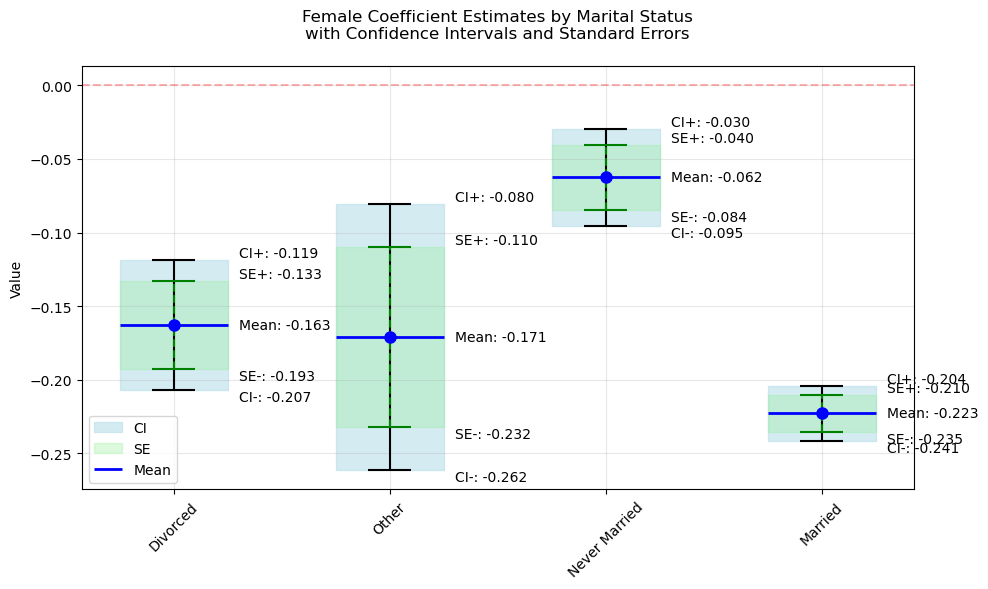

In [7]:
# Get estimates and standard errors
estimates = control_fit.params[1:5]  # female:divorced, female:other, female:nevermarried, female:married
se = np.sqrt(np.diag(control_fit.cov_HC0[1:5,1:5]))

# Create confidence intervals
ci_lower = estimates - c * se
ci_upper = estimates + c * se

# Create plot
plt.figure(figsize=(10, 6))
marital_status = ['Divorced', 'Other', 'Never Married', 'Married']

# Create box plot data
box_data = []
for i in range(4):
    box_data.append({
        'mean': estimates[i],
        'q1': ci_lower[i],
        'q3': ci_upper[i],
        'whislo_ci': ci_lower[i],
        'whishi_ci': ci_upper[i],
        'whislo_se': estimates[i] - 1.5*se[i],
        'whishi_se': estimates[i] + 1.5*se[i]
    })

# Plot boxes
for i, data in enumerate(box_data):
    # Draw CI box
    plt.fill_between([i-0.25, i+0.25], [data['q1']]*2, [data['q3']]*2, 
                     color='lightblue', alpha=0.5, label='CI' if i==0 else "")
    
    # Draw SE box
    plt.fill_between([i-0.25, i+0.25], 
                     [data['whislo_se']]*2, [data['whishi_se']]*2,
                     color='lightgreen', alpha=0.3, label='SE' if i==0 else "")
    
    # Draw mean line
    plt.hlines(y=data['mean'], xmin=i-0.25, xmax=i+0.25, color='blue', 
              linewidth=2, label='Mean' if i==0 else "")
    
    # Draw CI whiskers
    plt.vlines(x=i, ymin=data['whislo_ci'], ymax=data['whishi_ci'], 
              color='black', linestyle='-')
    plt.hlines(y=[data['whislo_ci'], data['whishi_ci']], 
              xmin=i-0.1, xmax=i+0.1, color='black')
    
    # Draw SE whiskers  
    plt.vlines(x=i, ymin=data['whislo_se'], ymax=data['whishi_se'], 
              color='green', linestyle='--')
    plt.hlines(y=[data['whislo_se'], data['whishi_se']], 
              xmin=i-0.1, xmax=i+0.1, color='green')
    
    # Plot mean point and add text annotations
    plt.plot(i, data['mean'], 'bo', markersize=8)
    
    # Add text annotations
    plt.text(i+0.3, data['mean'], f'Mean: {data["mean"]:.3f}', verticalalignment='center')
    plt.text(i+0.3, data['whishi_se'], f'SE+: {data["whishi_se"]:.3f}', verticalalignment='bottom')
    plt.text(i+0.3, data['whislo_se'], f'SE-: {data["whislo_se"]:.3f}', verticalalignment='top')
    plt.text(i+0.3, data['whishi_ci'], f'CI+: {data["whishi_ci"]:.3f}', verticalalignment='bottom')
    plt.text(i+0.3, data['whislo_ci'], f'CI-: {data["whislo_ci"]:.3f}', verticalalignment='top')

plt.xticks(range(4), marital_status, rotation=45)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Female Coefficient Estimates by Marital Status\nwith Confidence Intervals and Standard Errors', pad=20)
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('coefficient_estimates.png', dpi=300, bbox_inches='tight')
plt.show()
